In [ ]:
!pip install -q nltk gensim pyLDAvis transformers torch matplotlib numpy pandas sklearn nltk

In [636]:
import json
from pathlib import Path
import pandas as pd
from datetime import datetime
import random

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import sklearn
from sklearn.manifold import TSNE
import numpy as np
import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from transformers import pipeline
from scipy.spatial import ConvexHull


nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/lea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Load Data

In [2]:
sentences = []
urls = []
dates = []
sent_labels = []
sent_scores = []
data_path = Path(os.path.abspath('')).parent / 'final_datasets/future_statements_distilbert_sentiments.jsonl'
with open(data_path, 'r', encoding='utf-8') as f:
    for json_obj in f:
        obj = json.loads(json_obj) #.rstrip('\n|\r'))
        sentence = obj['sentence']
        if sentence not in sentences:
            sentences.append(obj['sentence'])
            urls.append(obj['url'])
            dates.append(obj['timestamp'])
            sent_labels.append(obj['sent_label'])
            sent_scores.append(obj['sent_score'])

print(sentences[:10])

['She’s landed an opening slot for OMD’s first US Tour in 20 years and I expect those performances will catapult her into superstardom.', 'Scroll down\xa0 for video Ray Kurzweil – director of engineering at Google -\xa0 claims that by 2045 humans will be able to upload their entire minds to\xa0 computers and become digitally immortal – an event called singularity.', 'The conference was created by Russian\xa0 multimillionaire Dmitry Itskov and featured visonary talks about how the world\xa0 will look by 2045.', 'Ray Kurzweil, pictured, said that ‘frail, biological parts’ of human bodies will be replaced with ‘non-biological’ parts in the future.', '‘But in the future it’s not going to be a\xa0 little picture in a virtual environment you’re looking at.', 'Obamacare will push the equivalent of about 2 million workers out of the labor market by 2017 as employees decide either to work fewer hours or drop out altogether, according to the latest estimates Tuesday from the Congressional Budget

In [3]:
data = pd.DataFrame(
    zip(
        urls, 
        sentences,
        dates,
        sent_labels,
        sent_scores
    ), 
    columns=[
        'url', 
        'sentence', 
        'datetime', 
        'sent_label',
        'sent_score'
    ]
)

### Sentiment comparison

In [4]:
print('Sentimet labels:')
print('positive: ', len(data[data['sent_label'] == 'positive'])/len(data)*100)
print('negative: ', len(data[data['sent_label'] == 'negative'])/len(data)*100)
print('neutral: ', len(data[data['sent_label'] == 'neutral'])/len(data)*100)

Sentimet labels:
positive:  5.479162259361117
negative:  11.439602284747197
neutral:  83.08123545589169


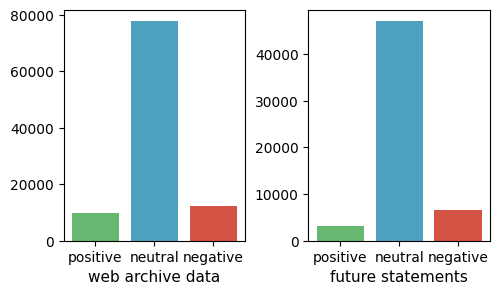

In [5]:
colors = ['#66B770', '#4DA1BF', '#D55344']

fig, axes = plt.subplots(1, 2, figsize=(5.5, 3))

labels = ['positive', 'neutral', 'negative']
future_statement_count = [9679, 77988, 12333]
web_archive_count = [len(data[data['sent_label'] == 'positive']),
            len(data[data['sent_label'] == 'neutral']), 
            len(data[data['sent_label'] == 'negative'])]

axes[0].bar(labels, future_statement_count, color=colors)
axes[0].set_xlabel('web archive data', fontsize=11)
axes[1].bar(labels, web_archive_count, color=colors)
axes[1].set_xlabel('future statements', fontsize=11)

plt.subplots_adjust(wspace=0.35)
plt.show()

### Sentiments over time

In [6]:
def parse_date(text):
    for fmt in ('%Y-%m-%dT%H:%M:%S%z', '%Y-%m-%dT%H:%M:%S'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    #raise ValueError(f'no valid date format found for {text}')
    print(f'no valid date format found for {text}')

In [78]:
time_data = data.copy()
# remove rows without date entry
time_data = time_data[(time_data['datetime'] != '1970-01-01T00:00:00+00:00')]
time_data['datetime'] = time_data['datetime'].apply(lambda x: parse_date(x))
#time_data = time_data[time_data['datetime'].apply(lambda x: x.year < 2013)]
time_data['year_month'] = time_data['datetime'].apply(lambda x: datetime.strptime(str(x.year) + '-' + str(x.month), '%Y-%m'))
time_data['year_month_day'] = time_data['datetime'].apply(lambda x: datetime.strptime(str(x.year) + '-' + str(x.month) + '-' + str(x.day), '%Y-%m-%d'))
print(len(data) - len(time_data), 'rows removed')

187 rows removed


In [9]:
print(time_data['year_month'].min(), time_data['year_month'].max())

1970-01-01 00:00:00 2014-05-01 00:00:00


In [79]:
time_data = time_data.set_index('year_month')

missing_dates = pd.DataFrame(index=pd.date_range('1970-01-01', '2014-05-01', freq='MS').difference(time_data.index))
time_data = pd.concat([time_data, missing_dates]).sort_index()
time_data['year_month'] = time_data.index
#time_data.reset_index()
time_data['year'] = time_data['year_month'].apply(lambda x: x.year)
time_data['month'] = time_data['year_month'].apply(lambda x: x.month)

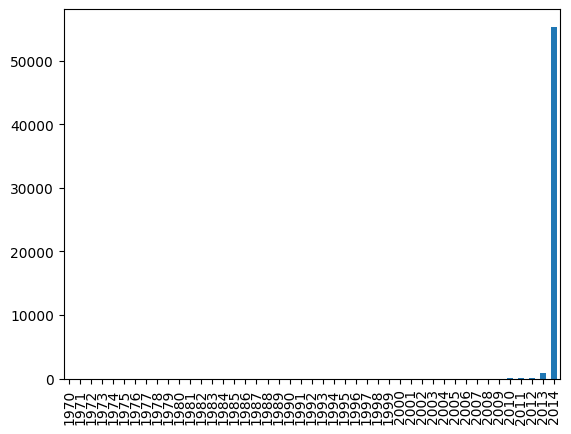

In [80]:
time_data.set_index('datetime')
df = time_data.resample('Y').size()
ax = df.plot.bar()
ax.set_xticklabels(df.index.strftime('%Y'))

plt.show()

<AxesSubplot:title={'center':'1970-2014'}, xlabel='year_month'>

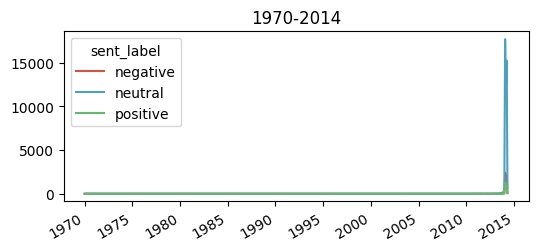

In [81]:
colors = ['#D55344', '#4DA1BF', '#66B770']

fig, ax = plt.subplots(figsize=(6, 2.5))
ax.axes.xaxis.get_label().set_visible(False)
ax.set_title('1970-2014')
time_data.groupby(['year_month', 'sent_label']).size().unstack(fill_value=0).plot(ax=ax, color=colors)

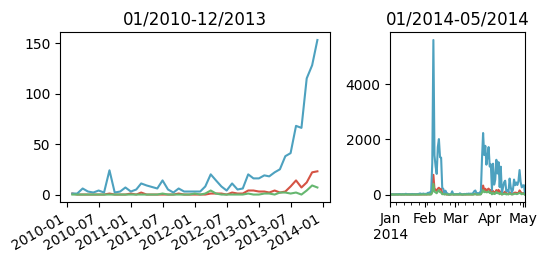

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), gridspec_kw={'width_ratios': [2, 1]})

axes[0].axes.xaxis.get_label().set_visible(False)
axes[0].set_title('01/2010-12/2013')
time_data[(time_data['year_month_day'] <= datetime(2013, 12, 31)) & (time_data['year'] >= 2010)].groupby(['year_month', 'sent_label']).size().unstack(fill_value=0).plot(ax=axes[0], color=colors, legend=False)

axes[1].axes.xaxis.get_label().set_visible(False)
axes[1].set_title('01/2014-05/2014')
time_data[time_data['year_month_day'] >= datetime(2014, 1, 1)].reset_index().groupby(['year_month_day', 'sent_label']).size().unstack(fill_value=0).plot(ax=axes[1], color=colors, legend=False)

plt.subplots_adjust(wspace=0.3)

In [398]:
grouped_time_data = time_data.groupby(['year', 'sent_label']).size().unstack(fill_value=0).stack().to_frame().reset_index()
grouped_time_data = grouped_time_data.rename(columns={0: 'count'})
grouped_time_data = pd.DataFrame(grouped_time_data) 
grouped_time_data.head()

year sent_label  count
0  1970   negative      1
1  1970    neutral      0
2  1970   positive      0
3  1996   negative      0
4  1996    neutral      2

In [399]:
time_data_pos = grouped_time_data[grouped_time_data['sent_label'] == 'positive']
time_data_pos = time_data_pos.rename(columns={"count": "positive"})
time_data_pos = time_data_pos.drop(columns=['sent_label'])
time_data_neg = grouped_time_data[grouped_time_data['sent_label'] == 'negative']
time_data_neg = time_data_neg.rename(columns={"count": "negative"})
time_data_neg = time_data_neg.drop(columns=['sent_label'])
time_data_neu = grouped_time_data[grouped_time_data['sent_label'] == 'neutral']
time_data_neu = time_data_neu.rename(columns={"count": "neutral"})
time_data_neu = time_data_neu.drop(columns=['sent_label'])

In [400]:
time_data_stacked = pd.concat([time_data_pos.set_index('year'), time_data_neg.set_index('year'), time_data_neu.set_index('year')], axis=1, join='inner')
time_data_stacked.tail()

positive  negative  neutral
year                             
2010         0         2       55
2011         1         4       67
2012         8        15      118
2013        29       103      709
2014      3054      6322    45932

In [ ]:
time_data_stacked = time_data_stacked.apply(lambda x: x*100/sum(x), axis=1)
time_data_stacked['year_col'] = time_data_stacked.index
time_data_stacked[(time_data_stacked['year_col'] > 2003)][['neutral', 'positive', 'negative']].plot.bar(stacked=True, color=colors)

In [ ]:
time_data_stacked.groupby(['year_month']).plot.bar(stacked=True)

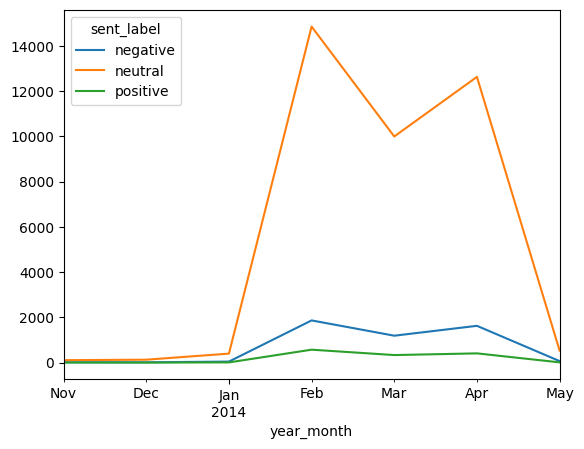

In [172]:
grouped_time_data = time_data[time_data['year_month'].apply(lambda x: x >= datetime(2013, 11, 1))].groupby(['year_month', 'sent_label']).size().unstack(fill_value=0).plot()

<AxesSubplot:xlabel='year_month'>

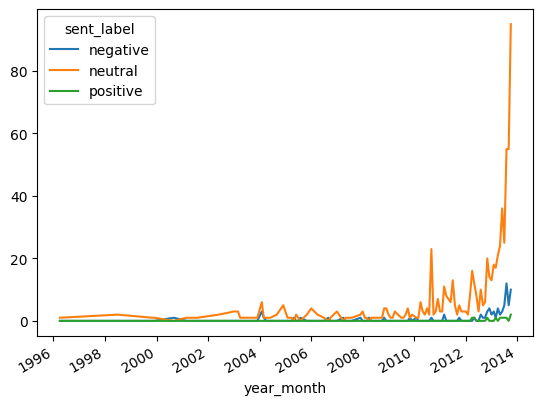

In [166]:
time_data[time_data['year_month'].apply(lambda x: x < datetime(2013, 11, 1))].groupby(['year_month', 'sent_label']).size().unstack(fill_value=0).plot()

In [ ]:
grouped_time_data.plot(x='year_month', y='count')

In [ ]:
fig, ax = plt.subplots()
ax.plot(grouped_time_data['year_month'], grouped_time_data[grouped_time_data['sentiment_label']=='positive'], label="positive")

plt.show()

### Topic Modelling

Preprocessing

In [462]:
porter_stemmer = PorterStemmer()
stop_words = stopwords.words('english')
stopword_extension = ['future', 'foreseeable', 'distant', 'near', 'years', 'year', 'someday', 'long', 'run', 'next', 
                    'will', 'going', 'predict', 'expect', 'forecast', 'estimate', 'presume', 'speculate', 'envision', 'imagine', 'foretell', 'believe', 'anticipate']
stop_words.extend(stopword_extension)

lda_data = data.copy()
lda_data['prep_sentence'] = lda_data['sentence'].apply(lambda x: gensim.utils.simple_preprocess(x.lower(), deacc=True))
lda_data['prep_sentence'] = lda_data['prep_sentence'].apply(lambda x: [word for word in x if word not in stop_words])
lda_data.head()

url  \
0             http://according2g.com/2011/01/page/2/   
1  http://nanobrainimplant.com/category/computerb...   
2  http://nanobrainimplant.com/category/computerb...   
3  http://nanobrainimplant.com/category/computerb...   
4  http://nanobrainimplant.com/category/computerb...   

                                            sentence  \
0  She’s landed an opening slot for OMD’s first U...   
1  Scroll down  for video Ray Kurzweil – director...   
2  The conference was created by Russian  multimi...   
3  Ray Kurzweil, pictured, said that ‘frail, biol...   
4  ‘But in the future it’s not going to be a  lit...   

                    datetime sent_label  sent_score  \
0  2014-02-08T13:53:59+00:00    neutral    0.996698   
1  2014-02-08T03:26:41+00:00    neutral    0.998910   
2  2014-02-08T03:26:41+00:00    neutral    0.998405   
3  2014-02-08T03:26:41+00:00    neutral    0.998423   
4  2014-02-08T03:26:41+00:00    neutral    0.999008   

                                       prep_sentence  
0  [landed, opening, slot, omd, first, us, tour, ...  
1  [scroll, video, ray, kurzweil, director, engin...  
2  [conference, created, russian, dmitry, itskov,...  
3  [ray, kurzweil, pictured, said, frail, biologi...  
4   [little, picture, virtual, environment, looking]

### LDA

In [ ]:
prep_sentences = lda_data['prep_sentence'].tolist()

dictionary = corpora.Dictionary(prep_sentences)

corpus = [dictionary.doc2bow(text) for text in prep_sentences]

In [465]:
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=20,
    passes=50,
    alpha='auto',
    random_state=0
)

print(lda_model.print_topics(num_words=10))

[(0, '0.024*"time" + 0.024*"one" + 0.021*"people" + 0.020*"us" + 0.019*"see" + 0.019*"make" + 0.019*"also" + 0.018*"like" + 0.017*"get" + 0.017*"think"'), (1, '0.049*"end" + 0.036*"big" + 0.031*"children" + 0.030*"soon" + 0.026*"benefit" + 0.021*"kids" + 0.020*"young" + 0.017*"affect" + 0.014*"personal" + 0.013*"moment"'), (2, '0.044*"government" + 0.036*"support" + 0.022*"problems" + 0.022*"financial" + 0.020*"ensure" + 0.019*"issues" + 0.019*"area" + 0.017*"security" + 0.017*"women" + 0.015*"often"'), (3, '0.034*"perhaps" + 0.030*"show" + 0.027*"price" + 0.025*"level" + 0.025*"feel" + 0.024*"return" + 0.019*"second" + 0.017*"model" + 0.015*"pretty" + 0.015*"lower"'), (4, '0.026*"city" + 0.020*"small" + 0.018*"face" + 0.017*"gas" + 0.017*"income" + 0.016*"purchase" + 0.015*"expand" + 0.014*"tax" + 0.014*"eventually" + 0.013*"works"'), (5, '0.038*"need" + 0.037*"would" + 0.030*"better" + 0.028*"probably" + 0.027*"look" + 0.021*"keep" + 0.020*"past" + 0.018*"best" + 0.017*"less" + 0.016

In [ ]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

### Data Preparation

In [659]:
indices = [6, 10, 11, 12, 13, 18, 19]

In [660]:
topic_dict = {tup[0]: tup[1] for tup in lda_model.print_topics(num_words=10) if tup[0] in indices}
topic_ids = [lda_model.get_document_topics(c) for c in corpus]
topic_ids = [[t for t in r if t[0] in indices] for r in topic_ids] 
sentence_topic_ids = [[t[0] for t in tuples if t[0] in indices] for tuples in topic_ids]
sentence_topic_probability = [[t[1] for t in tuples if t[0] in indices] for tuples in topic_ids]
sentence_topic_terms = [[topic_dict[id] for id in ids if id in indices] for ids in sentence_topic_ids]

In [641]:
#https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
topic_matrix = [[0 for col in range(len(topic_dict))] for row in range(len(topic_ids))]
for i, e in enumerate(topic_ids):
    for j, topic in enumerate(e):
        topic_matrix[i][j] = topic[1]

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, perplexity=20, n_iter=5000, learning_rate=3, random_state=0, init='pca', verbose=1)
tsne_lda = tsne_model.fit_transform(np.array(topic_matrix))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 56724 samples in 0.046s...
[t-SNE] Computed neighbors for 56724 samples in 4.479s...
[t-SNE] Computed conditional probabilities for sample 1000 / 56724
[t-SNE] Computed conditional probabilities for sample 2000 / 56724
[t-SNE] Computed conditional probabilities for sample 3000 / 56724
[t-SNE] Computed conditional probabilities for sample 4000 / 56724
[t-SNE] Computed conditional probabilities for sample 5000 / 56724
[t-SNE] Computed conditional probabilities for sample 6000 / 56724
[t-SNE] Computed conditional probabilities for sample 7000 / 56724
[t-SNE] Computed conditional probabilities for sample 8000 / 56724
[t-SNE] Computed conditional probabilities for sample 9000 / 56724
[t-SNE] Computed conditional probabilities for sample 10000 / 56724
[t-SNE] Computed conditional probabilities for sample 11000 / 56724
[t-SNE] Computed conditional probabilities for sample 12000 / 56724
[t-SNE] Computed conditional probabilities for sam

/home/lea/miniconda3/envs/futurenv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 122.382950
[t-SNE] KL divergence after 5000 iterations: 2.211378


In [661]:
tsne_df = pd.DataFrame(tsne_lda.tolist(), columns=['tsne_x', 'tsne_y'])
lda_plot_data = pd.concat([lda_data.reset_index(), tsne_df], axis=1)

lda_plot_data['marker_size'] = lda_plot_data['sent_score']*100
lda_plot_data['marker_color'] = lda_plot_data['sent_label'].apply(lambda x: 'red' if x == 'negative' else ('green' if x == 'positive' else 'blue'))

max_topic_ids = []
max_topic_values = []
for i, v in enumerate(sentence_topic_probability):
    max_indices = [i for i, x in enumerate(v) if x == max(v)]
    max_i = random.choice(max_indices)
    max_topic_ids.append(sentence_topic_ids[i][max_i])
    max_topic_values.append(v[max_i])
lda_plot_data['max_topic_ids'] =  max_topic_ids
lda_plot_data['max_topic_values'] = max_topic_values

### Plotting

In [500]:
# create polygons for topics
# https://www.machinelearningplus.com/plots/top-50-matplotlib-visualizations-the-master-plots-python/
def encircle(x,y, ax=None, **kw):
    if not ax: ax=plt.gca()
    p = np.c_[x,y]
    hull = ConvexHull(p)
    coords = p[hull.vertices,:]
    poly = plt.Polygon(coords, **kw)
    ax.add_patch(poly)
    
    coords_list = list(zip(*coords))
    center_x = sum(coords_list[0]) / len(coords)
    center_y = sum(coords_list[1]) / len(coords)
    
    return ax, (center_x, center_y)

In [624]:
topic_labels = {
    0: '?',
    1: 'children',
    2: 'financial problems/support',
    3: 'price development',
    4: 'expenses',
    5: '?',
    6: 'growth prospects',
    7: 'family',
    8: 'housing',
    9: 'america',
    10: 'technology/internet',
    11: '(climate) change',
    12: 'economy',
    13: 'finances',
    14: '?',
    15: '?',
    16: 'studying',
    17: '?',
    18: 'internet/social media',
    19: 'healthcare',
               }

In [662]:
lda_plot_data['max_topic_label'] = lda_plot_data['max_topic_ids'].apply(lambda x: topic_labels[x])
lda_plot_data.tail()

index                                                url  \
56719  56719  http://pl.trustpilot.com/review/www.theoutdoor...   
56720  56720      http://ch.trustpilot.com/review/e-careers.com   
56721  56721  http://nursamad.blogspot.com/2012_01_01_archiv...   
56722  56722  http://livelaughrv.net/2013/07/25/unlikely-bon...   
56723  56723  http://welcomebacktopottersville.blogspot.com/...   

                                                sentence  \
56719  The Outdoor Shop will be the first place I vis...   
56720  I am very happy with the service and would mos...   
56721  "The board of directors and the entire senior ...   
56722  Nope, won’t be leaving my camera behind in the...   
56723  So, sadly, we will be stuck with this most bru...   

                        datetime sent_label  sent_score  \
56719  2014-02-17T07:03:39+00:00    neutral    0.997263   
56720  2014-02-17T07:05:27+00:00   positive    0.999423   
56721  2014-02-15T20:28:36+00:00    neutral    0.996999   
56722  2014-02-17T07:07:29+00:00    neutral    0.995844   
56723  2014-02-16T11:00:02+00:00   negative    0.999054   

                                           prep_sentence     tsne_x  \
56719               [outdoor, shop, first, place, visit] -18.536631   
56720  [happy, service, would, definitely, make, use,... -52.126751   
56721  [board, directors, entire, senior, management,... -14.193811   
56722                    [nope, leaving, camera, behind]   1.036752   
56723  [sadly, stuck, brutal, barbaric, embarrassing,...  10.103454   

          tsne_y  marker_size marker_color  max_topic_ids  max_topic_values  \
56719 -11.097214    99.726272         blue             10          0.058405   
56720  23.257677    99.942267        green             10          0.078222   
56721  11.293836    99.699855         blue             10          0.070893   
56722  -7.969418    99.584371         blue             10          0.061980   
56723 -56.596214    99.905437          red             12          0.065432   

           max_topic_label  
56719  technology/internet  
56720  technology/internet  
56721  technology/internet  
56722  technology/internet  
56723              economy

([], [])

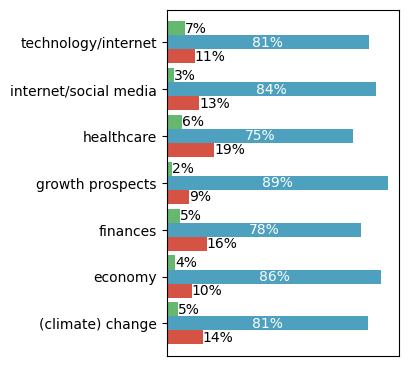

In [764]:
stacked_lda_data = pd.DataFrame(lda_plot_data.groupby(['max_topic_label', 'sent_label']).agg('size'))
stacked_lda_data = stacked_lda_data.reset_index().rename(columns={0:'count'})
stacked_lda_data = stacked_lda_data.set_index('max_topic_label').pivot(columns=['sent_label'], values='count')
fig, ax = plt.subplots(figsize=(3, 4.5))

ax.yaxis.get_label().set_visible(False)
stacked_lda_data.apply(lambda x: x*100/sum(x), axis=1).plot(kind = 'barh', color=['#D55344', '#4DA1BF', '#66B770'], ax=ax, width=0.9, legend=False)
for i, container in enumerate(ax.containers):
    if i == 1:
        ax.bar_label(container, label_type='center', fmt='%.f%%', color='white')
    else:
        ax.bar_label(container, fmt='%.f%%')

plt.xticks([])
    


In [ ]:
from matplotlib import patches
from scipy.spatial import ConvexHull

colors = ['#4DA1BF', '#66B770', '#D55344']
sentiments = ['neutral', 'positive', 'negative']

fig = plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')    

threshold = 0.1

for i, sent in enumerate(sentiments):
    plt.scatter('tsne_x', 'tsne_y', data=lda_plot_data[(lda_plot_data['sent_label']==sent) & (lda_plot_data['max_topic_values'] >= threshold)], s='marker_size', label=sent, alpha=0.5, color=colors[i])

ids = [6, 10, 11, 12, 13, 18, 19]
for id, value in topic_dict.items():
    temp_data = lda_plot_data[(lda_plot_data['max_topic_ids'] == id) & (lda_plot_data['max_topic_values'] >= threshold)]
    if len(temp_data) > 0 and id in ids:
        ax, center_coords = encircle(temp_data['tsne_x'], temp_data['tsne_y'], ec="k", fc="gray", alpha=0.0)
        ax.annotate(topic_labels[id], xy=center_coords, color='black', fontsize=22)

plt.legend(fontsize=16)    
plt.show()   